# Data Exploration

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from research.strings import TARGET, PREDICTORS, DETAILS

In [2]:
# Filter to explore only the training data
SPLIT_DATE = 16252
FIGSIZE = (6, 6)
df = pd.read_csv("data/inspections.csv")
df = df.query("Inspection_Date < {}".format(SPLIT_DATE))
print("Training Data: N = {}".format(len(df)))
df.head()[DETAILS].T

Training Data: N = 17075


,0,1,2,3,4
address,3352 N BROADWAY,6059 N LINCOLN AVE,6259 N MCCORMICK RD,3253 W BRYN MAWR AVE,2112 W PETERSON AVE
aka_name,SEVEN STAR,PANERA BREAD,LITTLE QUIAPO RESTAURANT,SERGIO'S TAQUERIA PIZZA,TARGET
city,CHICAGO,CHICAGO,CHICAGO,CHICAGO,CHICAGO
dba_name,SEVEN STAR,PANERA BREAD,LITTLE QUIAPO RESTAURANT,SERGIO'S TAQUERIA PIZZA INC.,TARGET STORE # T-2079
facility_type,Grocery Store,Restaurant,Restaurant,Restaurant,Grocery Store
inspection_date,2013-01-31T00:00:00.000,2011-10-18T00:00:00.000,2011-10-18T00:00:00.000,2011-10-19T00:00:00.000,2011-10-20T00:00:00.000
inspection_type,Canvass,Canvass,Canvass,Canvass,Canvass
latitude,41.9434,41.9919,41.9956,41.9829,41.9907
license_id,30790,1.47589e+06,1.74013e+06,1.44736e+06,1.67946e+06
longitude,-87.645,-87.7096,-87.7127,-87.711,-87.683


## What risk levels are covered in inspections?

In [3]:
df["risk"].value_counts()

Risk 1 (High)      12862
Risk 2 (Medium)     3324
Risk 3 (Low)         889
Name: risk, dtype: int64

## When do inspections take place?

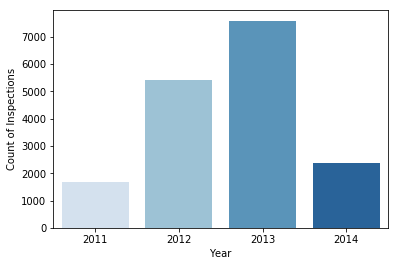

In [4]:
year_hist = pd.to_datetime(df["inspection_date"]).dt.year
year_hist = year_hist.value_counts().sort_index()
sns.barplot(year_hist.index, year_hist.values, palette="Blues")
plt.xlabel("Year")
plt.ylabel("Count of Inspections")
plt.show()

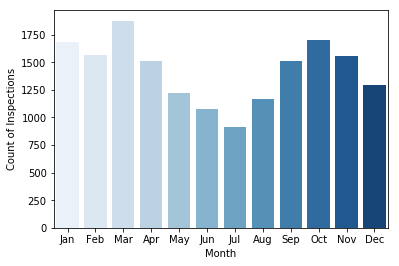

In [5]:
month_hist = pd.to_datetime(df["inspection_date"]).dt.month
month_hist = month_hist.value_counts().sort_index()
month_hist.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
sns.barplot(month_hist.index, month_hist.values, palette="Blues")
plt.xlabel("Month")
plt.ylabel("Count of Inspections")
plt.show()

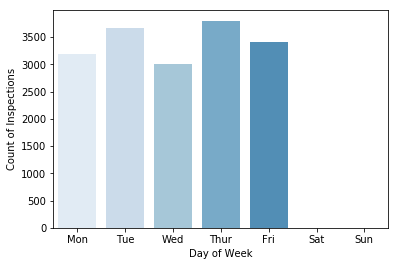

In [6]:
day_hist = pd.to_datetime(df["inspection_date"]).dt.weekday
day_hist = day_hist.value_counts().sort_index()
day_hist.index = ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"]
sns.barplot(day_hist.index, day_hist.values, palette="Blues")
plt.xlabel("Day of Week")
plt.ylabel("Count of Inspections")
plt.show()

## What types of facilities are covered in inspections?

In [7]:
fac_counts = df["facility_type"].value_counts()
pd.DataFrame(fac_counts.values, fac_counts.index, columns=["Count"]).query("Count > 1").head(15)

,Count
Restaurant,13760
Grocery Store,2349
Bakery,335
School,138
Catering,132
Hospital,46
BANQUET HALL,15
Long Term Care,15
Liquor,13
GAS STATION,10


## Where in the city are critical violations found?

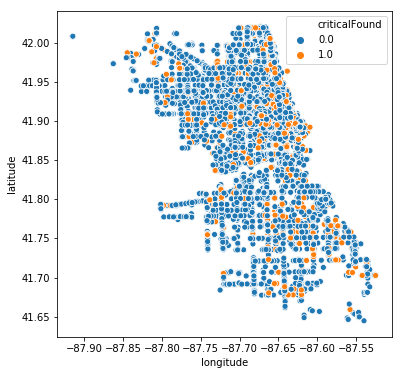

In [8]:
sns.scatterplot(x="longitude", y="latitude", hue=TARGET, data=df).figure.set_size_inches(FIGSIZE)

## Which businesses had the most critical violations?

In [9]:
biz_counts = df.query("{} > 0".format(TARGET))["License"].value_counts()
biz_df = pd.DataFrame()
biz_df["License"] = biz_counts.index
biz_df["Criticals"] = biz_counts.values
biz_df.sort_values(by="Criticals", ascending=False).head()
biz_df.set_index("License").join(
    df.set_index("License")["dba_name"]
).drop_duplicates().sort_values(by="Criticals", ascending=False).head(15)

,Criticals,dba_name
License,,
2065037,4,SOUTH BRANCH
11030,3,KINCADE'S
1769408,3,CHOP SUEY HUANG
1948824,3,"PITA KABAB, INC."
1381615,3,"ANDIAMO'S O'HARE, LLC"
9821,3,FURAMA RESTAURANT INC
2094329,3,FRANKS 'N' DAWGS
1823586,3,DEMERA ETHIOPIAN RESTAURANT
14616,3,"ILLINOIS SPORTSERVICE, INC."


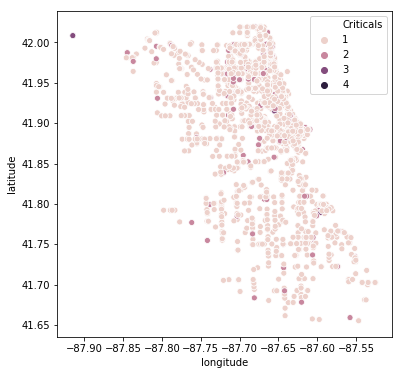

In [10]:
sns.scatterplot(x="longitude", y="latitude", hue="Criticals", data=biz_df.set_index("License").join(
    df.set_index("License")[["longitude", "latitude"]]
).drop_duplicates()).figure.set_size_inches(FIGSIZE)

## How much earlier does the algorithm catch critical violations?

In [11]:
from sklearn.linear_model import LogisticRegression
import pickle
test = pd.read_csv("data/test_data.csv")
clf = pickle.load(open("models/sklearn-glm.pkl", "rb"))
test.head()

,criticalFound,Inspection_Date,License,Inspection_ID,Business_ID,Inspector_blue,Inspector_brown,Inspector_green,Inspector_orange,Inspector_purple,...,pastSerious,pastCritical,timeSinceLast,ageAtInspection,consumption_on_premises_incidental_activity,tobacco_retail_over_counter,temperatureMax,heat_burglary,heat_sanitation,heat_garbage
0,0.0,16324,2021618,920471.0,2021618-20121216,1,0,0,0,0,...,0.0,0.0,2.000000,1,0.0,0.0,77.946667,70.000000,44.398934,18.826366
1,0.0,16339,43618,1115257.0,43618-20140616,0,0,0,1,0,...,1.0,0.0,1.917808,1,0.0,0.0,72.263333,25.084509,52.785171,11.752896
2,0.0,16346,67839,1155245.0,67839-20121116,0,0,0,1,0,...,0.0,0.0,1.936986,1,0.0,0.0,65.810000,12.395546,13.437666,41.032810
3,0.0,16364,2183764,1155246.0,2183764-20130416,0,0,0,1,0,...,0.0,0.0,1.115068,0,0.0,0.0,55.386667,6.591129,12.044724,6.493034
4,1.0,16316,2008126,1199491.0,2008126-20130516,1,0,0,0,0,...,0.0,1.0,1.342466,1,0.0,0.0,82.030000,9.700997,14.368083,0.453519


In [12]:
pd.DataFrame(clf.coef_[0], PREDICTORS).round(3)

,0
Inspector_blue,0.950
Inspector_brown,-1.306
Inspector_green,-0.244
Inspector_orange,0.202
Inspector_purple,1.555
Inspector_yellow,-0.697
pastSerious,0.302
pastCritical,0.427
timeSinceLast,0.097
ageAtInspection,-0.164


In [13]:
X = test[PREDICTORS]
y = test[TARGET]

In [14]:
from datetime import datetime
SECONDS = 60 * 60 * 24
res = pd.DataFrame()
res["ID"] = test["Inspection_ID"].astype(int)
res["Critical"] = test["criticalFound"].astype(int)
res["Score"] = clf.predict_proba(X)[:,1]
res["TimeBAU"] = test["Inspection_Date"].apply(lambda d: datetime.fromtimestamp(d * SECONDS))
res["DayBAU"] = (res["TimeBAU"] - res["TimeBAU"].min()).apply(lambda dt: dt.days)
res.sort_values(by="DayBAU", ascending=True).head()

,ID,Critical,Score,TimeBAU,DayBAU
211,1408254,0,0.337572,2014-09-01 19:00:00,0
313,1424472,0,0.087954,2014-09-02 19:00:00,1
198,1387639,0,0.108801,2014-09-02 19:00:00,1
659,1471451,0,0.028864,2014-09-02 19:00:00,1
660,1471452,0,0.065082,2014-09-02 19:00:00,1


In [15]:
dd_order = res.sort_values(by="Score", ascending=False).reset_index(drop=True)
sim = pd.DataFrame(dd_order)
sim["TimeDD"] = res.sort_values(by="TimeBAU", ascending=True).reset_index(drop=True)["TimeBAU"]
sim["DayDD"] = res.sort_values(by="TimeBAU", ascending=True).reset_index(drop=True)["DayBAU"]
sim.sort_values(by="Score", ascending=False).head()

,ID,Critical,Score,TimeBAU,DayBAU,TimeDD,DayDD
0,1497219,1,0.622373,2014-09-25 19:00:00,24,2014-09-01 19:00:00,0
1,1497839,1,0.618925,2014-10-14 19:00:00,43,2014-09-02 19:00:00,1
2,1501420,1,0.608030,2014-10-30 19:00:00,59,2014-09-02 19:00:00,1
3,1482406,1,0.580698,2014-09-22 19:00:00,21,2014-09-02 19:00:00,1
4,1482423,1,0.552807,2014-09-25 19:00:00,24,2014-09-02 19:00:00,1


In [16]:
def cumsum_from_groupby(groupby, valrange):
    return np.cumsum([groupby[t] if t in groupby.index else 0 for t in valrange])

In [17]:
time = range(len(sim))
bau_time_cumsum = sim.sort_values(by="DayBAU", ascending=True)["Critical"].cumsum().values
dd_time_cumsum = sim.sort_values(by="Score", ascending=False)["Critical"].cumsum().values
print(len(time), len(bau_time_cumsum), len(dd_time_cumsum))
days = range(sim["DayBAU"].max())
bau_day_cumsum = cumsum_from_groupby(sim.groupby(["DayBAU"])["Critical"].sum(), days)
dd_day_cumsum = cumsum_from_groupby(sim.groupby(["DayDD"])["Critical"].sum(), days)
print(len(days), len(bau_day_cumsum), len(dd_day_cumsum))

1637 1637 1637
59 59 59


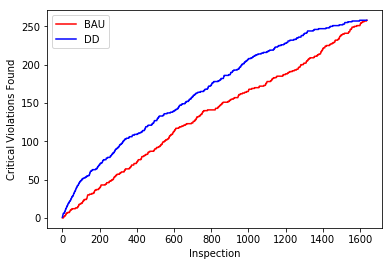

In [18]:
sns.lineplot(x=time, y=bau_time_cumsum, color="red", label="BAU")
sns.lineplot(x=time, y=dd_time_cumsum, color="blue", label="DD")
plt.xlabel("Inspection")
plt.ylabel("Critical Violations Found")
plt.show()

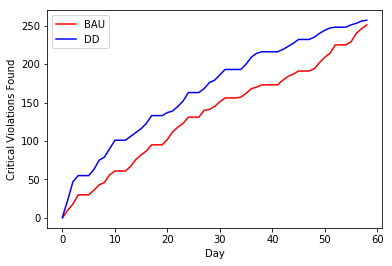

In [19]:
sns.lineplot(x=days, y=bau_day_cumsum, color="red", label="BAU")
sns.lineplot(x=days, y=dd_day_cumsum, color="blue", label="DD")
plt.xlabel("Day")
plt.ylabel("Critical Violations Found")
plt.show()

In [20]:
sim["Change"] = (sim["TimeBAU"] - sim["TimeDD"]).apply(lambda dt: dt.delta / (1e9 * SECONDS))
sim.head()

,ID,Critical,Score,TimeBAU,DayBAU,TimeDD,DayDD,Change
0,1497219,1,0.622373,2014-09-25 19:00:00,24,2014-09-01 19:00:00,0,24.0
1,1497839,1,0.618925,2014-10-14 19:00:00,43,2014-09-02 19:00:00,1,42.0
2,1501420,1,0.608030,2014-10-30 19:00:00,59,2014-09-02 19:00:00,1,58.0
3,1482406,1,0.580698,2014-09-22 19:00:00,21,2014-09-02 19:00:00,1,20.0
4,1482423,1,0.552807,2014-09-25 19:00:00,24,2014-09-02 19:00:00,1,23.0


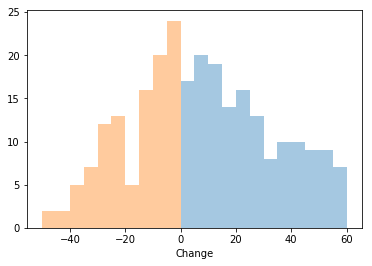

In [21]:
critical = sim.query("Critical > 0")
sns.distplot(critical.query("Change > 0")["Change"], kde=False, bins=range(0, 65, 5))
sns.distplot(critical.query("Change <= 0")["Change"], kde=False, bins=range(-50, 5, 5))

In [22]:
critical["Change"].describe().round(2)

count    258.00
mean       7.44
std       25.20
min      -50.00
25%       -9.00
50%        6.00
75%       25.00
max       58.00
Name: Change, dtype: float64

## How are the inspectors clustered?

In [23]:
from research.strings import INSPECTORS, OTHER_PREDICTORS

In [24]:
inspectors = df[INSPECTORS].idxmax(axis=1).apply(lambda x: str(x)[10:])
inspectors.head()

0    green
1     blue
2     blue
3     blue
4     blue
dtype: object

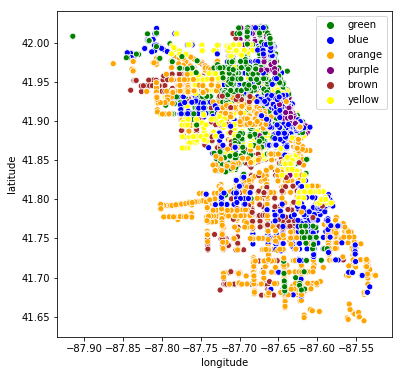

In [25]:
sns.scatterplot(
    x="longitude", y="latitude",
    hue=inspectors, data=df,
    palette=["green", "blue", "orange", "purple", "brown", "yellow"]
).figure.set_size_inches(FIGSIZE)

In [26]:
ins_sum = pd.DataFrame(
    clf.coef_[0][:,0][0:len(INSPECTORS)],
    INSPECTORS, columns=["Coefficient"]
)
ins_sum.round(3)

,Coefficient
Inspector_blue,0.950
Inspector_brown,-1.306
Inspector_green,-0.244
Inspector_orange,0.202
Inspector_purple,1.555
Inspector_yellow,-0.697


In [27]:
df_ins = pd.DataFrame(df)
df_ins["inspector"] = inspectors
df_ins[["inspector", TARGET] + OTHER_PREDICTORS].head().T

,0,1,2,3,4
inspector,green,blue,blue,blue,blue
criticalFound,0,0,0,0,0
pastSerious,0,0,0,0,0
pastCritical,0,0,0,0,0
timeSinceLast,2,2,2,2,2
ageAtInspection,1,1,1,1,1
consumption_on_premises_incidental_activity,0,0,0,0,0
tobacco_retail_over_counter,1,0,0,0,0
temperatureMax,53.4967,59.0467,59.0467,56.1533,52.73
heat_burglary,26.9924,13.9766,12.6112,35.9064,9.53079


In [28]:
ins_sum["count"] = df_ins.groupby(["inspector"]).size().values
ins_sum["hit_rate"] = df_ins.groupby(["inspector"])[TARGET].mean().values
ins_sum.round(3).sort_values(by="Coefficient", ascending=False)

,Coefficient,count,hit_rate
Inspector_purple,1.555,1174,0.406
Inspector_blue,0.950,2897,0.265
Inspector_orange,0.202,3769,0.136
Inspector_green,-0.244,4595,0.095
Inspector_yellow,-0.697,2762,0.058
Inspector_brown,-1.306,1878,0.024


In [29]:
from sklearn.linear_model import LogisticRegression

inspector_coefs = []
d_train = pd.read_csv("data/train_data.csv")
for inspector_color in INSPECTORS:
    X_train = d_train.query("{} > 0".format(inspector_color))[OTHER_PREDICTORS]
    y_train = d_train.query("{} > 0".format(inspector_color))[TARGET]
    logres = LogisticRegression(solver="sag", max_iter=5000)
    logres.fit(X_train, y_train)
    pd.DataFrame(logres.coef_[0], X_train.columns).round(3)
    inspector_coefs.append(logres.coef_[0])
ins_coefs = pd.DataFrame(inspector_coefs, columns=OTHER_PREDICTORS, index=INSPECTORS)

In [30]:
ins_order = ins_sum.sort_values(by="Coefficient", ascending=False).index
ins_coefs.T[ins_order].round(3)

,Inspector_purple,Inspector_blue,Inspector_orange,Inspector_green,Inspector_yellow,Inspector_brown
pastSerious,0.331,0.218,0.447,0.153,0.315,0.088
pastCritical,0.307,0.449,0.558,0.386,0.057,0.570
timeSinceLast,-0.051,0.119,0.120,0.079,-0.122,0.101
ageAtInspection,-0.030,-0.132,-0.271,-0.155,-0.308,-0.262
consumption_on_premises_incidental_activity,0.334,0.406,0.118,0.726,0.199,-0.317
tobacco_retail_over_counter,0.453,-0.166,0.148,0.378,0.529,0.731
temperatureMax,0.008,0.005,0.003,0.010,-0.003,-0.013
heat_burglary,0.001,0.004,0.001,-0.003,0.005,-0.021
heat_sanitation,-0.004,0.001,0.010,-0.001,0.002,0.002
heat_garbage,0.013,-0.010,-0.005,0.003,-0.011,0.013


## What types of violations are committed?

In [31]:
df[DETAILS].head().T

,0,1,2,3,4
address,3352 N BROADWAY,6059 N LINCOLN AVE,6259 N MCCORMICK RD,3253 W BRYN MAWR AVE,2112 W PETERSON AVE
aka_name,SEVEN STAR,PANERA BREAD,LITTLE QUIAPO RESTAURANT,SERGIO'S TAQUERIA PIZZA,TARGET
city,CHICAGO,CHICAGO,CHICAGO,CHICAGO,CHICAGO
dba_name,SEVEN STAR,PANERA BREAD,LITTLE QUIAPO RESTAURANT,SERGIO'S TAQUERIA PIZZA INC.,TARGET STORE # T-2079
facility_type,Grocery Store,Restaurant,Restaurant,Restaurant,Grocery Store
inspection_date,2013-01-31T00:00:00.000,2011-10-18T00:00:00.000,2011-10-18T00:00:00.000,2011-10-19T00:00:00.000,2011-10-20T00:00:00.000
inspection_type,Canvass,Canvass,Canvass,Canvass,Canvass
latitude,41.9434,41.9919,41.9956,41.9829,41.9907
license_id,30790,1.47589e+06,1.74013e+06,1.44736e+06,1.67946e+06
longitude,-87.645,-87.7096,-87.7127,-87.711,-87.683


In [32]:
narratives = df["violations"].values
code_array = []
for report in narratives:
    if pd.isnull(report):
        code_array.append([])
    else:
        codes = [int(comment.split(".")[0]) for comment in report.split(" | ")]
        code_array.append(codes)

In [33]:
VIOLATIONS = {}
for report in narratives:
    if not pd.isnull(report):
        for comment in report.split(" | "):
            parts = comment.split(".")
            code = int(parts[0])
            rule = parts[1].split(" - Comments:")[0]
            if code not in VIOLATIONS:
                VIOLATIONS[code] = rule

In [34]:
def get_violation_level(code):
    if code <= 14:
        return "critical"
    elif code <= 29:
        return "serious"
    elif code <= 44 or code == 70:
        return "minor"
    else:
        return "unknown"

In [35]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
vio_mat = pd.DataFrame(mlb.fit_transform(code_array), columns=mlb.classes_)
vio_mat.head()

,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,70
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [36]:
vio_ranks = pd.DataFrame(vio_mat.sum(), columns=["Count"])
vio_ranks["Rule"] = [VIOLATIONS[code] for code in vio_ranks.index]
vio_ranks["Level"] = [get_violation_level(code) for code in vio_ranks.index]
vio_ranks.query("Level == 'critical'").sort_values(by="Count", ascending=False).head(10)

,Count,Rule,Level
3,1292,POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATURE ...,critical
2,600,FACILITIES TO MAINTAIN PROPER TEMPERATURE,critical
8,409,SANITIZING RINSE FOR EQUIPMENT AND UTENSILS: ...,critical
12,319,HAND WASHING FACILITIES: WITH SOAP AND SANITA...,critical
11,235,"ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, DESI...",critical
6,211,"HANDS WASHED AND CLEANED, GOOD HYGIENIC PRACT...",critical
9,128,"WATER SOURCE: SAFE, HOT & COLD UNDER CITY PRE...",critical
4,81,SOURCE OF CROSS CONTAMINATION CONTROLLED I,critical
10,73,"SEWAGE AND WASTE WATER DISPOSAL, NO BACK SIPH...",critical
1,71,"SOURCE SOUND CONDITION, NO SPOILAGE, FOODS PR...",critical
